In [182]:
import matplotlib.pyplot as plt
import numpy as  np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector


In [184]:
df = pd.read_csv("full_data.csv", delimiter=',')
print(df.head())
print(df.columns.tolist())

   Device_type            Timestamp Heart rate  Activity type Sleep stage  \
0  Apple Watch  20250602074248+0200         42            0.0       Awake   
1  Apple Watch  20250602074813+0200         58            1.0       Awake   
2  Apple Watch  20250602075146+0200         60            1.0       Awake   
3  Apple Watch  20250602075658+0200         75            0.0       Awake   
4  Apple Watch  20250602080402+0200         84            0.0       Awake   

   Coffee  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
['Device_type', 'Timestamp', 'Heart rate', 'Activity type', 'Sleep stage', 'Coffee']


In [185]:
# Load dataset
df = pd.read_csv("train_data.csv")

# Replace commas with dots and convert to float in 'Heart rate' column
df["Heart rate"] = df["Heart rate"].astype(str).str.replace(",", ".", regex=False)
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")

In [186]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
df["Activity type"] = df["Activity type"].astype("category")

In [187]:

# How many coffee values are there? 16
print((df["Coffee"] != 0).sum())

# Transform Coffee -> Caffeine left in body
half_life, dose = 5, 75
events, caffeine_left = [], []

for t, c in zip(df["Timestamp"], df["Coffee"]):
    events = [(et, d) for et, d in events if (t - et).total_seconds() < 24*3600]
    total = sum(d * 0.5 ** ((t - et).total_seconds() / 3600 / half_life) for et, d in events)
    if c == 1.0:
        events.append((t, dose))
        total += dose
    caffeine_left.append(total)

df["Caffeine"] = pd.Series(caffeine_left).round(3)

# Clean Caffeine Column
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce").fillna(0).astype(float)

# Example
# for ts, val in df.loc[df["Caffeine"] > 0, ["Timestamp", "Caffeine"]].values:
#     print(ts.strftime("%Y-%m-%d %H:%M"), val)

coffee = df["Coffee"]
time = df["Timestamp"]
# print(df["Sleep stage"].unique())
print(df.head())


16
   Device_type                 Timestamp  Heart rate Activity type  \
0  Apple Watch 2025-06-02 07:42:48+02:00        42.0             0   
1  Apple Watch 2025-06-02 07:48:13+02:00        58.0             1   
2  Apple Watch 2025-06-02 07:51:46+02:00        60.0             1   
3  Apple Watch 2025-06-02 07:56:58+02:00        75.0             0   
4  Apple Watch 2025-06-02 08:04:02+02:00        84.0             0   

  Sleep stage  Coffee  Caffeine  
0       Awake       0       0.0  
1       Awake       0       0.0  
2       Awake       0       0.0  
3       Awake       0       0.0  
4       Awake       0       0.0  


# 2. Exploratory Data Analysis
<!-- <h1 style="color:darkblue;">2. Exploratory Data Analysis</h1> -->

In [188]:
# df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
# df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
print(df.head())

   Device_type                 Timestamp  Heart rate Activity type  \
0  Apple Watch 2025-06-02 07:42:48+02:00        42.0             0   
1  Apple Watch 2025-06-02 07:48:13+02:00        58.0             1   
2  Apple Watch 2025-06-02 07:51:46+02:00        60.0             1   
3  Apple Watch 2025-06-02 07:56:58+02:00        75.0             0   
4  Apple Watch 2025-06-02 08:04:02+02:00        84.0             0   

  Sleep stage  Coffee  Caffeine  
0       Awake       0       0.0  
1       Awake       0       0.0  
2       Awake       0       0.0  
3       Awake       0       0.0  
4       Awake       0       0.0  


### Plot Activity-Type, Sleep-Stage counts 

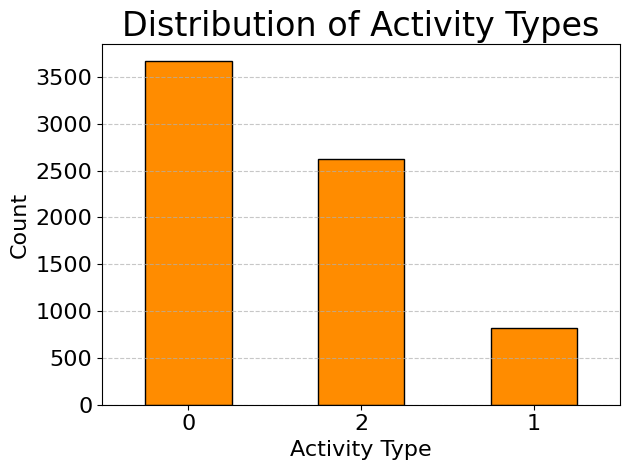

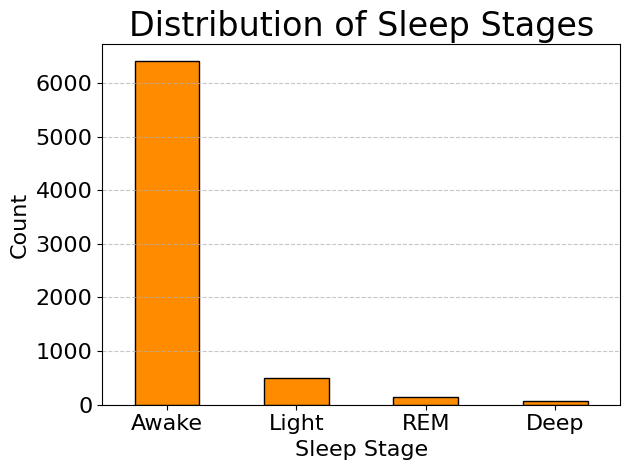

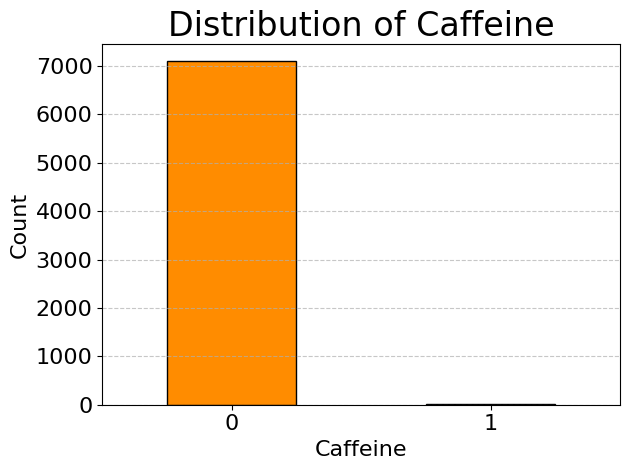

   Device_type                 Timestamp  Heart rate Activity type  \
0  Apple Watch 2025-06-02 07:42:48+02:00        42.0             0   
1  Apple Watch 2025-06-02 07:48:13+02:00        58.0             1   
2  Apple Watch 2025-06-02 07:51:46+02:00        60.0             1   
3  Apple Watch 2025-06-02 07:56:58+02:00        75.0             0   
4  Apple Watch 2025-06-02 08:04:02+02:00        84.0             0   

  Sleep stage  Coffee  Caffeine  
0       Awake       0       0.0  
1       Awake       0       0.0  
2       Awake       0       0.0  
3       Awake       0       0.0  
4       Awake       0       0.0  


In [189]:
#Activity type
activity_counts = df["Activity type"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Activity Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Activity Types", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.expanduser('~/Desktop/activity_type.png'), dpi=300)
plt.show()

#Sleep stage
activity_counts = df["Sleep stage"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Sleep Stage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Sleep Stages", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.expanduser('~/Desktop/sleep_stage.png'), dpi=300)
plt.show()

#Caffeine
activity_counts = df["Coffee"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Caffeine", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Caffeine", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.expanduser('~/Desktop/caffeine.png'), dpi=300)
plt.show()

print(df.head())

### Create various intervals (5min, 10min, 15min)


In [190]:
#Creating various intervals
def resample_df(df, interval="10min"):
    """
    Resample numerical and categorical columns in a time-indexed DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'Timestamp' column.
        interval (str): Time interval string for resampling (e.g., '10min', '1H').

    Returns:
        pd.DataFrame: Resampled dataframe with 'Timestamp' as a column.
    """
    # Ensure Timestamp is parsed and set as index
    df = df.copy()
    df.columns = df.columns.str.strip()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
    df = df.set_index("Timestamp").sort_index()

    # Define columns
    numerical_cols = ["Heart rate", "Caffeine"]
    categorical_cols = ["Activity type", "Sleep stage", "Coffee"]

    # Convert categoricals to string to avoid numeric aggregation
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Resample numericals using mean
    numerical_resampled = df[numerical_cols].resample(interval).mean()

    # Resample categoricals using mode
    categorical_resampled = pd.DataFrame(index=numerical_resampled.index)
    for col in categorical_cols:
        categorical_resampled[col] = df[col].resample(interval).agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    # Combine and reset index
    df_resampled = pd.concat([numerical_resampled, categorical_resampled], axis=1).reset_index()

    return df_resampled

df_5min = resample_df(df, "5min")
df_10min = resample_df(df, "10min")
df_15min = resample_df(df, "15min")

print(df.head())

   Device_type                 Timestamp  Heart rate Activity type  \
0  Apple Watch 2025-06-02 07:42:48+02:00        42.0             0   
1  Apple Watch 2025-06-02 07:48:13+02:00        58.0             1   
2  Apple Watch 2025-06-02 07:51:46+02:00        60.0             1   
3  Apple Watch 2025-06-02 07:56:58+02:00        75.0             0   
4  Apple Watch 2025-06-02 08:04:02+02:00        84.0             0   

  Sleep stage  Coffee  Caffeine  
0       Awake       0       0.0  
1       Awake       0       0.0  
2       Awake       0       0.0  
3       Awake       0       0.0  
4       Awake       0       0.0  


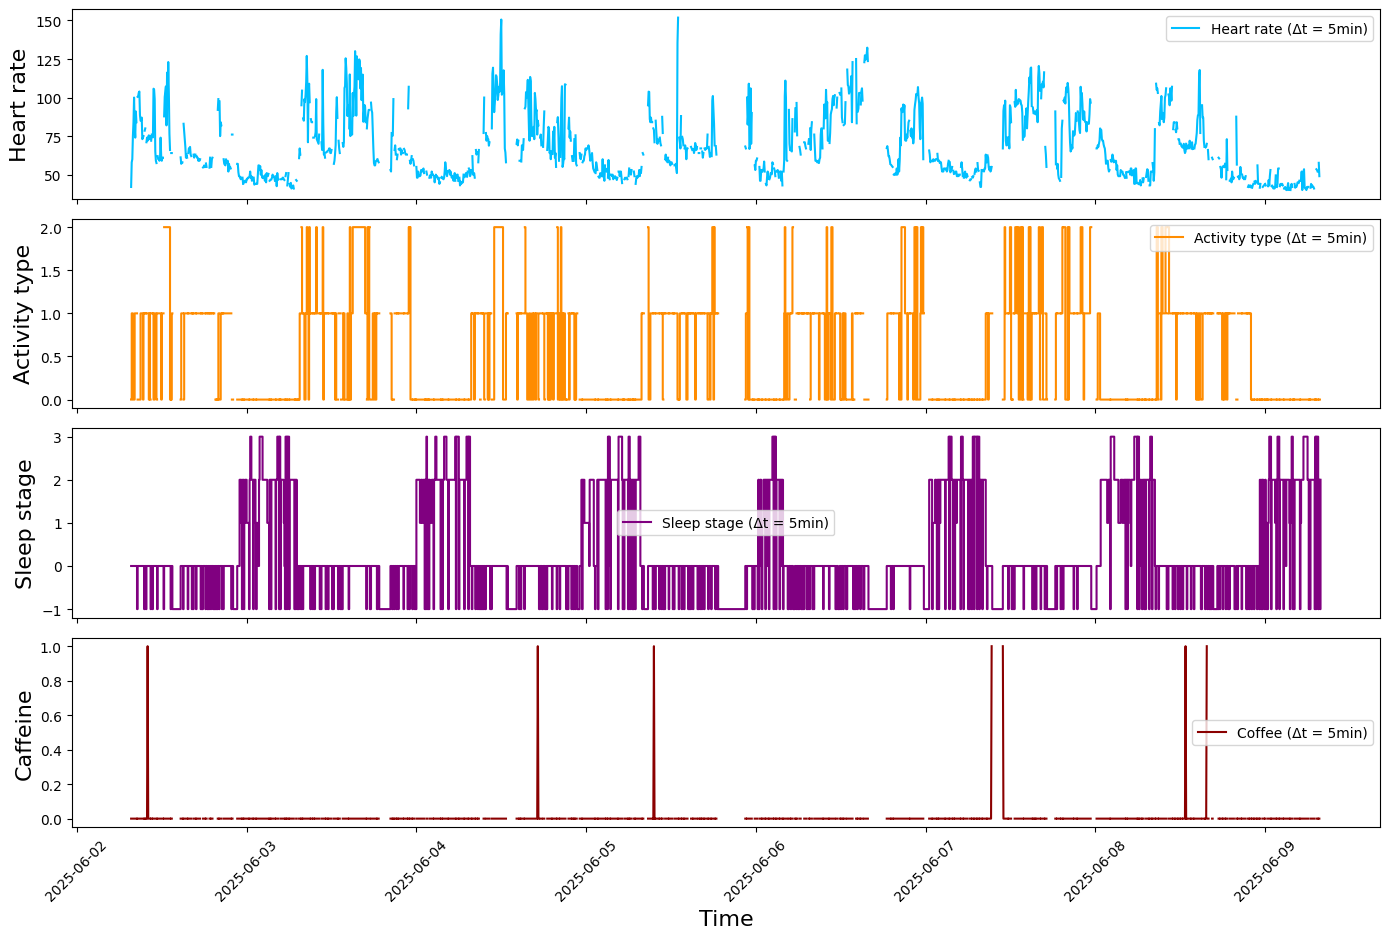

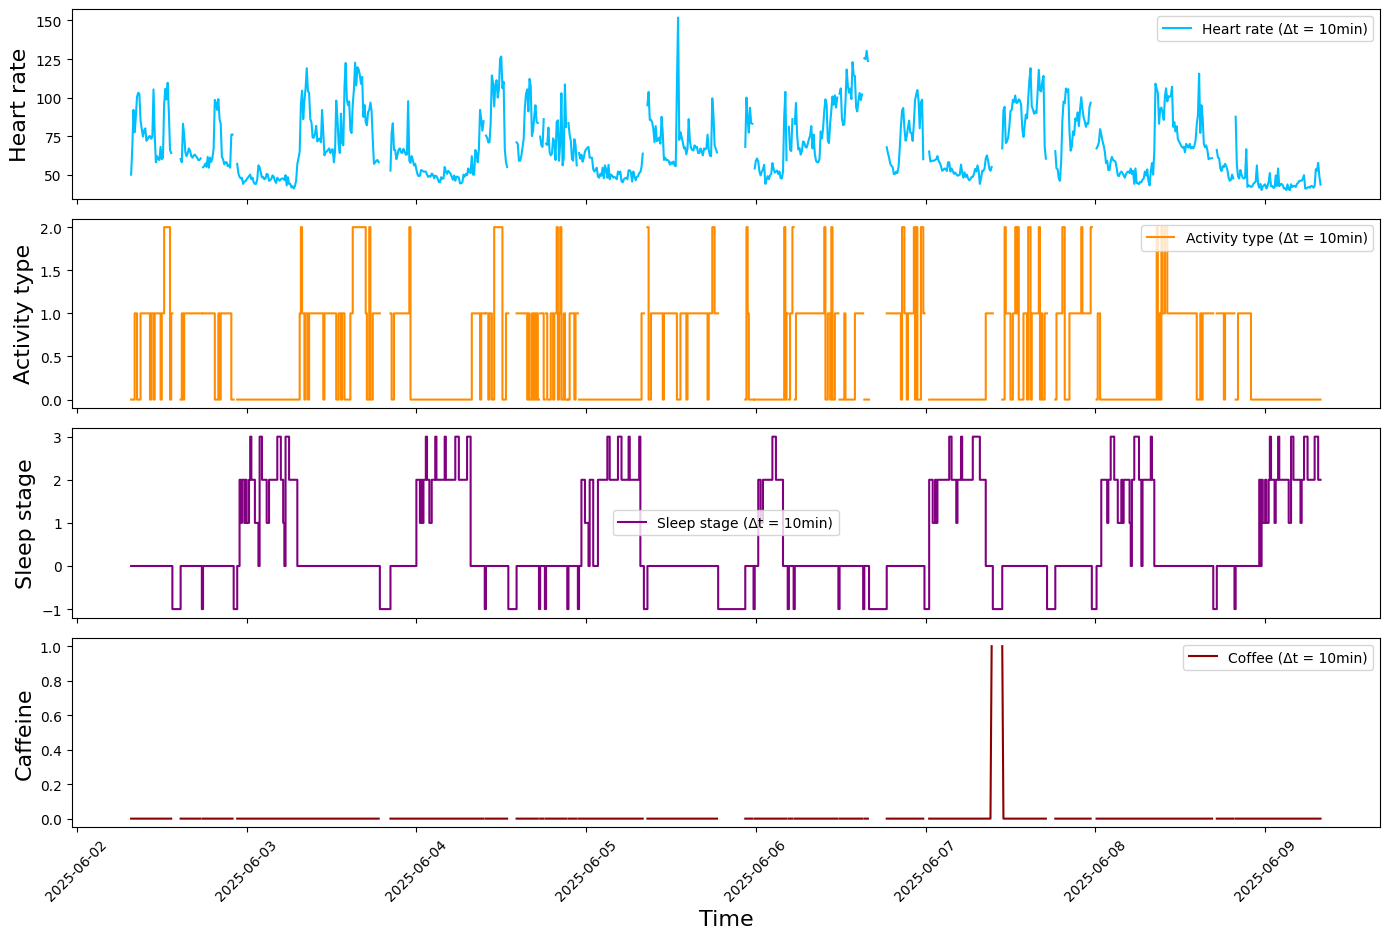

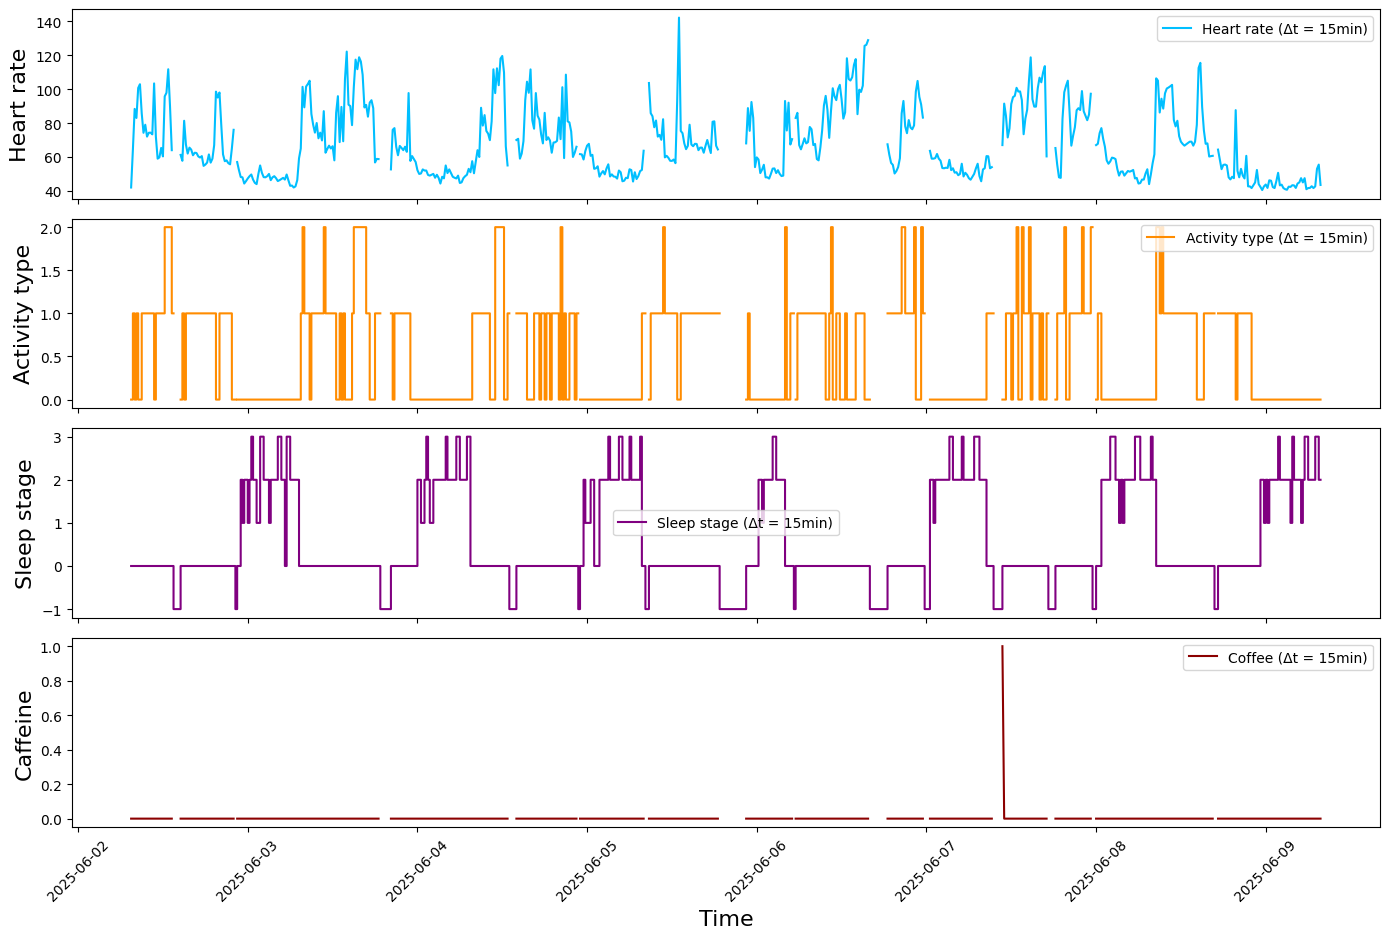

   Device_type                 Timestamp  Heart rate Activity type  \
0  Apple Watch 2025-06-02 07:42:48+02:00        42.0             0   
1  Apple Watch 2025-06-02 07:48:13+02:00        58.0             1   
2  Apple Watch 2025-06-02 07:51:46+02:00        60.0             1   
3  Apple Watch 2025-06-02 07:56:58+02:00        75.0             0   
4  Apple Watch 2025-06-02 08:04:02+02:00        84.0             0   

  Sleep stage  Coffee  Caffeine  
0       Awake       0       0.0  
1       Awake       0       0.0  
2       Awake       0       0.0  
3       Awake       0       0.0  
4       Awake       0       0.0  


In [191]:
def plot_sensor_overview(df_resampled, interval_label="10min", save_path="/Users/dora/Desktop/timeseries_plot.png"):
    """
    Plots 4 sensor/categorical measurements over time in subplots.
    
    Parameters:
        df_resampled (pd.DataFrame): Resampled dataframe with 'Timestamp' as a column.
        interval_label (str): Label for the time interval (e.g., '10min') to show in the title and legends.
        save_path (str): File path to save the resulting plot image.
    """

    # Ensure timestamp is in datetime format and set as index
    df_resampled = df_resampled.copy()
    df_resampled["Timestamp"] = pd.to_datetime(df_resampled["Timestamp"], errors="coerce")
    df_resampled = df_resampled.set_index("Timestamp")

    # Clean caffeine column
    df_resampled["Coffee"] = pd.to_numeric(df_resampled["Coffee"], errors="coerce")

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Heart rate
    axs[0].plot(df_resampled.index,
                df_resampled["Heart rate"],
                label=f"Heart rate (Δt = {interval_label})",
                color='deepskyblue')
    axs[0].set_ylabel("Heart rate", fontsize=16)
    axs[0].legend()

    # Plot 2: Activity type
    axs[1].plot(df_resampled.index,
                pd.to_numeric(df_resampled["Activity type"], errors='coerce'),
                drawstyle='steps-post',
                label=f"Activity type (Δt = {interval_label})",
                color='darkorange')
    axs[1].set_ylabel("Activity type", fontsize=16)
    axs[1].legend()

    # Plot 3: Sleep stage
    axs[2].plot(df_resampled.index,
                df_resampled["Sleep stage"].astype("category").cat.codes,
                drawstyle='steps-post',
                label=f"Sleep stage (Δt = {interval_label})",
                color='purple')
    axs[2].set_ylabel("Sleep stage", fontsize=16)
    axs[2].legend()

    # Plot 4: Caffeine
    axs[3].plot(df_resampled.index,
                df_resampled["Coffee"],
                label=f"Coffee (Δt = {interval_label})",
                color='darkred')
    axs[3].set_ylabel("Caffeine", fontsize=16)
    axs[3].legend()

    # Final formatting
    axs[-1].set_xlabel("Time", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for suptitle
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_sensor_overview(df_5min, interval_label="5min", save_path=os.path.expanduser('~/Desktop/5.png'))
plot_sensor_overview(df_10min, interval_label="10min", save_path=os.path.expanduser('~/Desktop/10.png'))
plot_sensor_overview(df_15min, interval_label="15min", save_path=os.path.expanduser('~/Desktop/15.png'))

print(df.head())

In [192]:
#For further anlysis we use df_10min
df = df_10min
print(df.isna().sum())

print(df.head())

Timestamp          0
Heart rate       105
Caffeine         105
Activity type    105
Sleep stage      105
Coffee           105
dtype: int64
                  Timestamp  Heart rate  Caffeine Activity type Sleep stage  \
0 2025-06-02 07:40:00+02:00        50.0       0.0             0       Awake   
1 2025-06-02 07:50:00+02:00        67.5       0.0             0       Awake   
2 2025-06-02 08:00:00+02:00        92.0       0.0             0       Awake   
3 2025-06-02 08:10:00+02:00        77.5       0.0             1       Awake   
4 2025-06-02 08:20:00+02:00        87.5       0.0             1       Awake   

  Coffee  
0      0  
1      0  
2      0  
3      0  
4      0  


# 3. Data Preprocessing
<!-- <h1 style="color:darkblue;">3. Data Preprocessing</h1> -->

### Data Cleaning

In [193]:
df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce")
df["Coffee"] = pd.to_numeric(df["Coffee"], errors="coerce")

### Outlier Removal

In [194]:
lower, upper = df['Heart rate'].quantile([0.01, 0.99])
df['Heart rate'] = df['Heart rate'].clip(lower, upper)

### Imputation

In [195]:
# Linear Interpolation
df['Coffee'] = pd.to_numeric(df['Coffee'], errors='coerce')
# Heart rate
# plot_feature('Heart rate')
df['Heart rate'] = df['Heart rate'].interpolate()
# plot_feature('Heart rate')

# Caffeine
# plot_feature('Caffeine')
df['Caffeine'] = df['Caffeine'].interpolate()
# plot_feature('Caffeine')

# Coffee
# plot_feature('Caffeine')
df['Coffee'] = df['Coffee'].interpolate()
# plot_feature('Caffeine')

# Activity Type
# plot_feature('Activity type', True)
df['Activity type'] = df['Activity type'].fillna(df['Activity type'].mode()[0])
# plot_feature('Activity type', True)
print(df.isna().sum())

Timestamp          0
Heart rate         0
Caffeine           0
Activity type      0
Sleep stage      105
Coffee             0
dtype: int64


### Kalman Filter (smooths out heart rate)

In [196]:
def plot_feature(feature, cat=False):

    # Ignore Missing Values
    f = df[feature]
    if cat: f = df[feature].astype("category").cat.add_categories("Unknown").fillna("Unknown")

    # Choose Color
    color_dict = {
    "Heart rate": "deepskyblue",
    "Caffeine": "brown",
    "Activity type": "darkorange",
    "Sleep stage": "purple"}
    color = color_dict.get(feature, "blue")

    # Plot
    fig, axs = plt.subplots(figsize=(14, 5))
    axs.plot(df["Timestamp"], f, color=color)
    axs.set_xlabel("Time", fontsize=16)
    axs.set_ylabel(f"{feature} Level", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{feature}_over_time.png", dpi=300)
    plt.show()

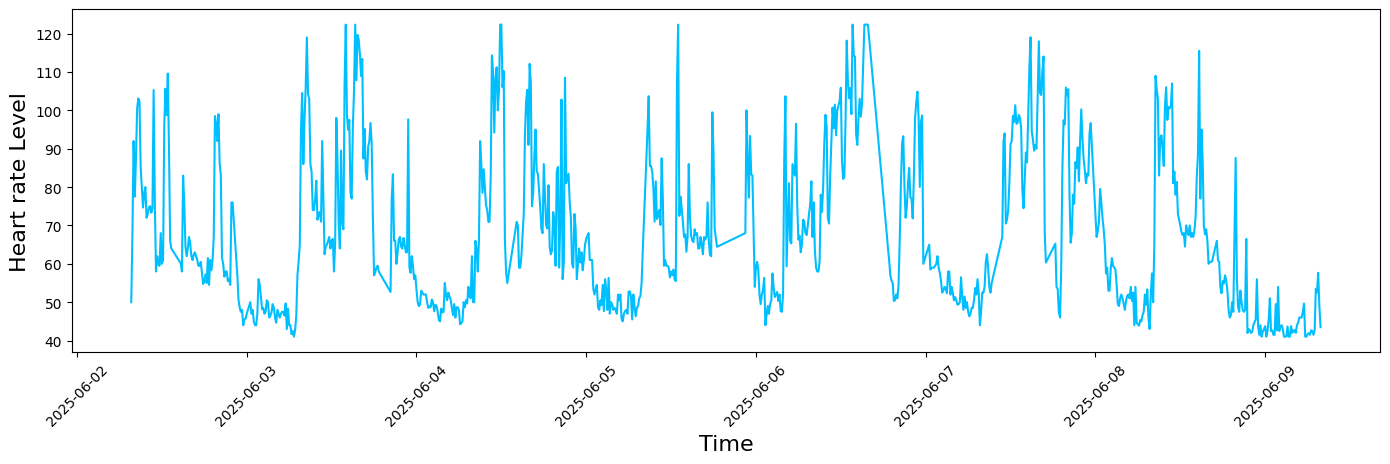

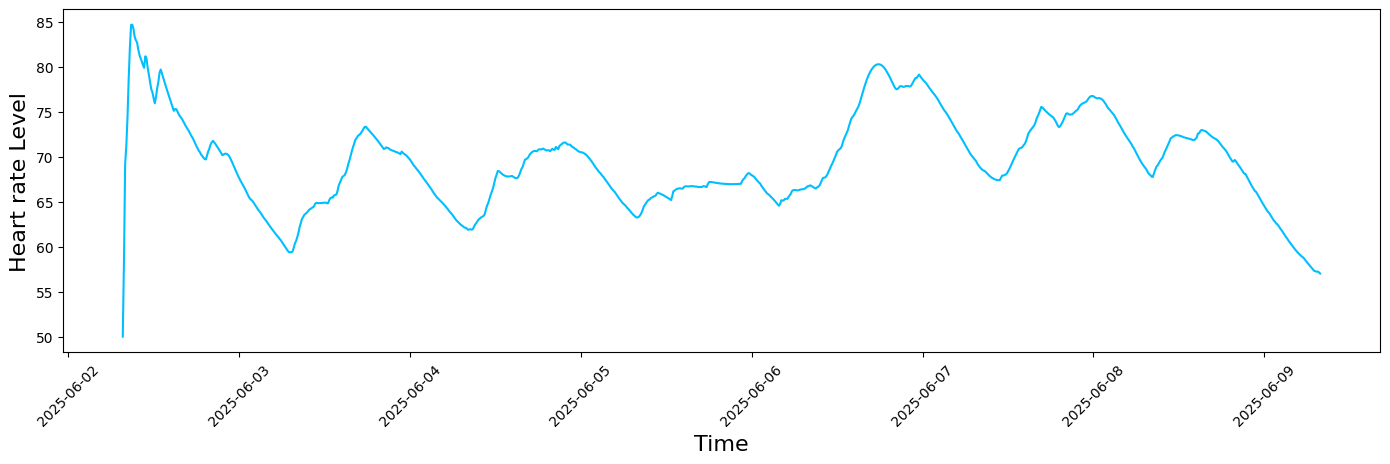

In [197]:
def kalman_1d(zs, Q=1e-5, R=0.1):
    x = zs[0]
    P = 1.0
    filtered = []
    for z in zs:
        # Predict
        P += Q
        # Update
        K = P / (P + R)
        x += K * (z - x)
        P *= (1 - K)
        filtered.append(x)
    return filtered

plot_feature('Heart rate')
df['Heart rate'] = kalman_1d(df['Heart rate'].values)
plot_feature('Heart rate')

# 4. Feature Engineering

### Time -> (Day-of-Week, Hour, Minute)

In [198]:
df["hour"] = df["Timestamp"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)  # Cyclic
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)  # Cyclic
df["minute"] = df["Timestamp"].dt.minute
df["day_of_week"] = df["Timestamp"].dt.dayofweek 

### Caffeine -> (Caffeine-Left, Hours-since-Caffeine)

In [199]:
#Hours since Caffeine intake
coffee = df["Coffee"]
time = df["Timestamp"]

# Get timestamps where coffee == 1
coffee_times = [t for t, c in zip(time, coffee) if c == 1]

# Compute hours since last caffeine
last = None
hours_since = []

for t in df["Timestamp"]:
    eligible = [ct for ct in coffee_times if ct <= t]
    if eligible:
        last = max(eligible)
        hours_since.append(0 if t == last else (t - last).total_seconds() / 3600)
    elif last:
        hours_since.append((t - last).total_seconds() / 3600)
    else:
        hours_since.append(-1)

df["hours_since_caffeine"] = hours_since

In [200]:
# Drop Caffeine column
# df.drop(columns=["Caffeine"], inplace=True)

### Heart Rate -> (rolling_mean/std/min/max/range, change, percent-change, low-medium-high)

In [201]:
n = 5
df["hr_rolling_mean"] = df["Heart rate"].rolling(window=n, min_periods=1).mean()  # smooths heart rate (trend)
df["hr_rolling_std"] = df["Heart rate"].rolling(window=n, min_periods=1).std().fillna(0)    # heart rate variability (volatility)
df["hr_min"] = df["Heart rate"].rolling(window=n, min_periods=1).min()         # rolling minimum over n points
df["hr_max"] = df["Heart rate"].rolling(window=n, min_periods=1).max()         # rolling maximum over n points
df["hr_range"] = df["hr_max"] - df["hr_min"]                                   # range in n-point window
df["hr_diff"] = df["Heart rate"].diff().fillna(0)                              # immediate heart rate change
df["hr_pct_change"] = df["Heart rate"].pct_change().fillna(0)                  # relative heart rate change (%)
df["hr_level"] = pd.cut(df["Heart rate"], bins=[0, 60, 90, np.inf], labels=["low", "medium", "high"]) 
df = pd.get_dummies(df, columns=["hr_level"], prefix="hr")
dummy_cols = ["hr_low", "hr_medium", "hr_high"]
df[dummy_cols] = df[dummy_cols].astype(int)


# 5. Modelling

In [148]:
print(df.isna().sum())

Timestamp                 0
Heart rate                0
Caffeine                  0
Activity type             0
Sleep stage             105
Coffee                    0
hour                      0
hour_sin                  0
hour_cos                  0
minute                    0
day_of_week               0
hours_since_caffeine      0
hr_rolling_mean           0
hr_rolling_std            0
hr_min                    0
hr_max                    0
hr_range                  0
hr_diff                   0
hr_pct_change             0
hr_low                    0
hr_medium                 0
hr_high                   0
dtype: int64


In [149]:
print(df.head())

                  Timestamp  Heart rate  Caffeine Activity type Sleep stage  \
0 2025-06-02 07:40:00+02:00   50.000000       0.0             0       Awake   
1 2025-06-02 07:50:00+02:00   58.333817       0.0             0       Awake   
2 2025-06-02 08:00:00+02:00   69.195848       0.0             0       Awake   
3 2025-06-02 08:10:00+02:00   71.222004       0.0             1       Awake   
4 2025-06-02 08:20:00+02:00   74.415773       0.0             1       Awake   

   Coffee  hour  hour_sin  hour_cos  minute  ...  hr_rolling_mean  \
0     0.0     7  0.965926 -0.258819      40  ...        50.000000   
1     0.0     7  0.965926 -0.258819      50  ...        54.166909   
2     0.0     8  0.866025 -0.500000       0  ...        59.176555   
3     0.0     8  0.866025 -0.500000      10  ...        62.187917   
4     0.0     8  0.866025 -0.500000      20  ...        64.633489   

   hr_rolling_std  hr_min     hr_max   hr_range    hr_diff  hr_pct_change  \
0        0.000000    50.0  50.000

In [150]:
#Function to train models
def train_and_evaluate(X, y, model, param_grid, model_name="Model", label_names=None, use_rfecv=True):
    # 0. Feature selection (optional)
    if use_rfecv:
        print(f"\n🔍 Running RFECV for feature selection on {model_name}...")
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring="f1_macro",
            n_jobs=-1
        )
        rfecv.fit(X, y)
        X = X.loc[:, rfecv.support_]
        print("✅ Selected features:", list(X.columns))

        # Plot RFECV scores
        plt.figure(figsize=(8, 5))
        plt.plot(
            range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
            rfecv.cv_results_["mean_test_score"],
            marker='o'
        )
        plt.xlabel("Number of Selected Features", fontsize=20)
        plt.xticks(fontsize=20)
        plt.ylabel("Cross-Validated F1 Macro Score", fontsize=20)
        plt.yticks(fontsize=20)
        plt.title(f"RFECV Results for {model_name}", fontsize=24)
        plt.grid(True)
        plt.tight_layout()
        graph_path = os.path.expanduser(f"~/Desktop/{model_name.replace(' ', '_').lower()}_rfecv_plot.png")
        plt.savefig(graph_path, dpi=300)
        plt.show()

    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 3. Grid search with F1 macro
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # 4. Predict and evaluate
    y_pred = grid_search.best_estimator_.predict(X_test)

    print(f"\n📊 {model_name} Results")
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best CV F1 Macro Score:", grid_search.best_score_)
    print("Test F1 Macro Score:", f1_score(y_test, y_pred, average="macro"))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names if label_names is not None else None))

    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_names if label_names is not None else sorted(set(y))
    )
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name}", fontsize=24)
    plt.xlabel("Predicted Label", fontsize=20)
    plt.ylabel("True Label", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    cm_path = os.path.expanduser(f"~/Desktop/{model_name.replace(' ', '_').lower()}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300)
    plt.show()

    return grid_search.best_estimator_

y = df["Sleep stage"]
df = df.dropna(subset=["Sleep stage"])
X = df.drop(columns=["Sleep stage", "Timestamp"])

le = LabelEncoder()
y = le.fit_transform(df["Sleep stage"])
label_names = le.classes_  # ['Awake', 'Deep', 'Light', 'REM']


## Random Forest


🔍 Running RFECV for feature selection on Random Forest...
✅ Selected features: ['Heart rate', 'Caffeine', 'Activity type', 'hour', 'hour_sin', 'hour_cos', 'minute', 'day_of_week', 'hours_since_caffeine', 'hr_rolling_mean', 'hr_rolling_std', 'hr_min', 'hr_max', 'hr_range', 'hr_diff', 'hr_pct_change', 'hr_low', 'hr_medium']


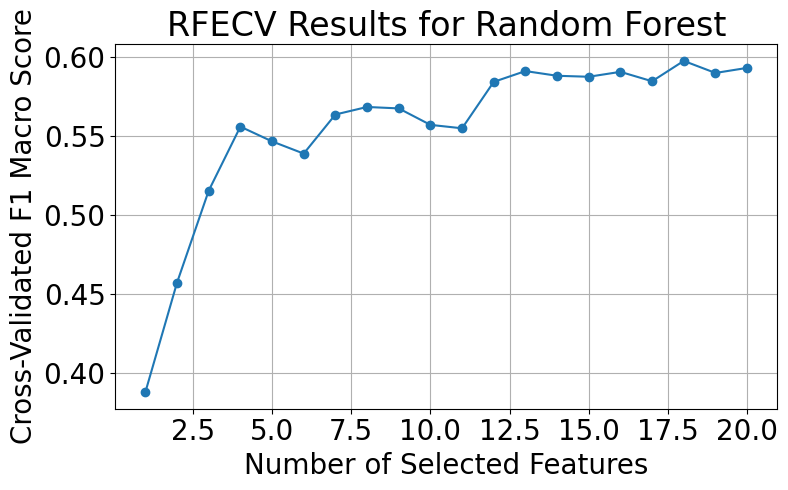


📊 Random Forest Results
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1 Macro Score: 0.5666287056713221
Test F1 Macro Score: 0.5569814709775005

Classification Report:
              precision    recall  f1-score   support

       Awake       0.97      1.00      0.98       121
        Deep       0.33      0.14      0.20         7
       Light       0.73      0.76      0.74        42
         REM       0.33      0.27      0.30        11

    accuracy                           0.87       181
   macro avg       0.59      0.54      0.56       181
weighted avg       0.85      0.87      0.86       181



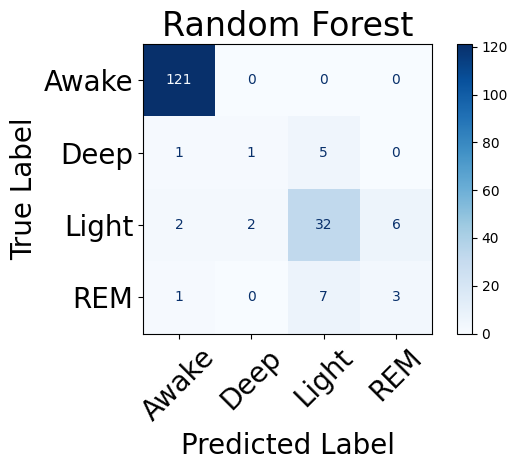

In [70]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

best_rf = train_and_evaluate(X, y, rf_model, rf_grid, model_name="Random Forest", label_names=label_names)


## K-NN


✅ Best number of features: 13
✅ Final selected features: ['Activity type', 'Coffee', 'hour', 'hour_sin', 'hour_cos', 'hours_since_caffeine', 'hr_rolling_std', 'hr_range', 'hr_diff', 'hr_pct_change', 'hr_low', 'hr_medium', 'hr_high']

📊 k-NN Results
Best hyperparameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best CV F1 Macro Score: 0.5777397229568573
Test F1 Macro Score: 0.6305448527958901

Classification Report:
              precision    recall  f1-score   support

       Awake       0.97      0.96      0.96       121
        Deep       0.40      0.29      0.33         7
       Light       0.72      0.79      0.75        42
         REM       0.50      0.45      0.48        11

    accuracy                           0.86       181
   macro avg       0.65      0.62      0.63       181
weighted avg       0.86      0.86      0.86       181



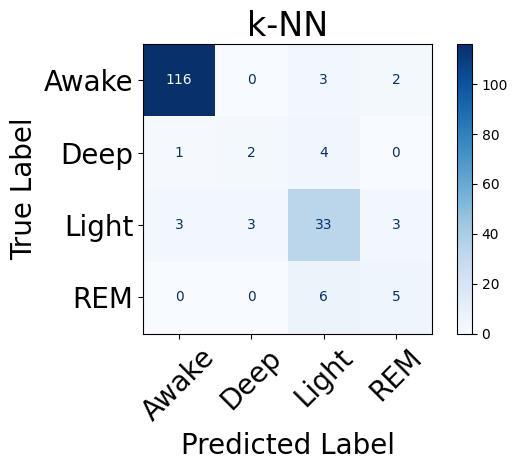

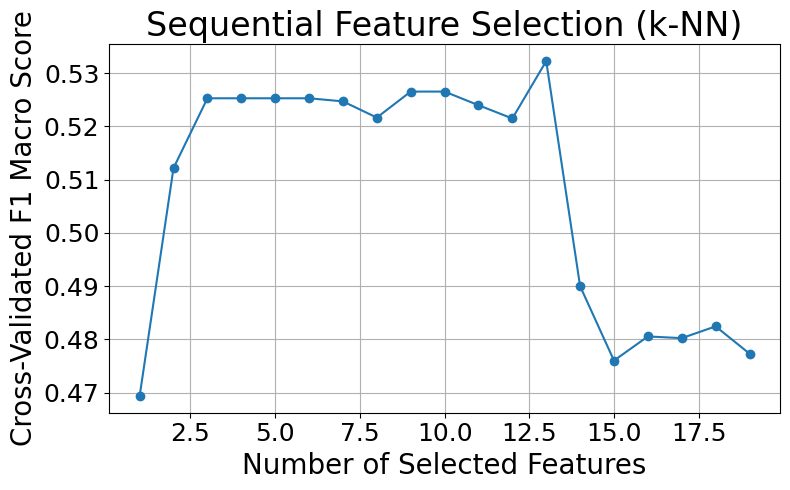

In [71]:
# k-NN (with scaling)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier()

# Store results
scores = []
feature_counts = range(1, X.shape[1])

for k in feature_counts:
    sfs = SequentialFeatureSelector(
        estimator=knn,
        n_features_to_select=k,
        direction="forward",
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1
    )
    sfs.fit(X, y)
    selected_features = X.columns[sfs.get_support()]
    X_k = X[selected_features]
    
    score = cross_val_score(knn, X_k, y, cv=cv, scoring="f1_macro", n_jobs=-1).mean()
    scores.append(score)

# Select best number of features
best_k = feature_counts[scores.index(max(scores))]
print(f"\n✅ Best number of features: {best_k}")

# Final SFS with best_k
final_sfs = SequentialFeatureSelector(
    estimator=knn,
    n_features_to_select=best_k,
    direction="forward",
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)
final_sfs.fit(X, y)
X_selected = X.loc[:, final_sfs.get_support()]
print("✅ Final selected features:", list(X_selected.columns))

# Define pipeline and grid
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])
knn_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "knn__weights": ["uniform", "distance"]
}

# Train and evaluate
best_knn = train_and_evaluate(
    X_selected, y,
    knn_pipeline,
    knn_grid,
    model_name="k-NN",
    label_names=label_names,
    use_rfecv=False
)

# Plot sfs graph
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, scores, marker='o')
plt.xlabel("Number of Selected Features", fontsize=20)
plt.ylabel("Cross-Validated F1 Macro Score", fontsize=20)
plt.title("Sequential Feature Selection (k-NN)", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.tight_layout()
graph_path = os.path.expanduser("~/Desktop/knn_sfs_plot.png")
plt.savefig(graph_path, dpi=300)
plt.show()


## XGBoost

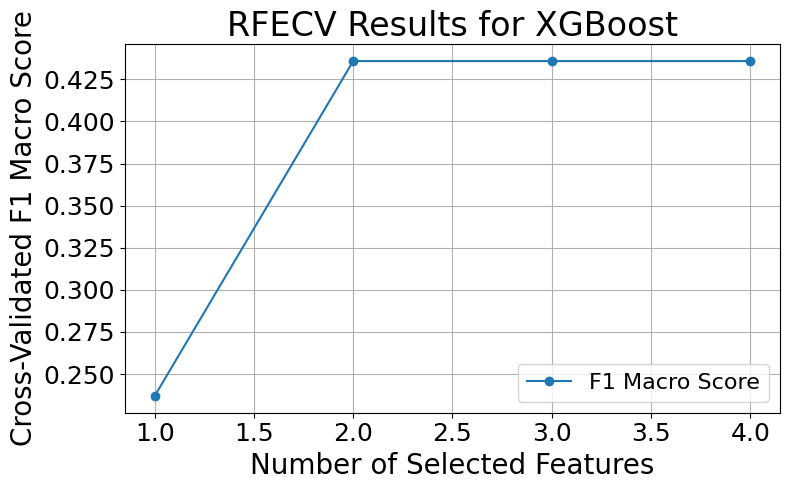

Selected features: ['Heart rate', 'Activity type']

📊 XGBoost Results
Best hyperparameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__n_estimators': 100}
Best CV F1 Macro Score: 0.44334048380137264
Test F1 Macro Score: 0.43604105413863525

Classification Report:
              precision    recall  f1-score   support

       Awake       0.99      0.99      0.99      1281
        Deep       0.00      0.00      0.00        13
       Light       0.64      0.91      0.75        99
         REM       0.00      0.00      0.00        29

    accuracy                           0.96      1422
   macro avg       0.41      0.48      0.44      1422
weighted avg       0.94      0.96      0.95      1422



C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

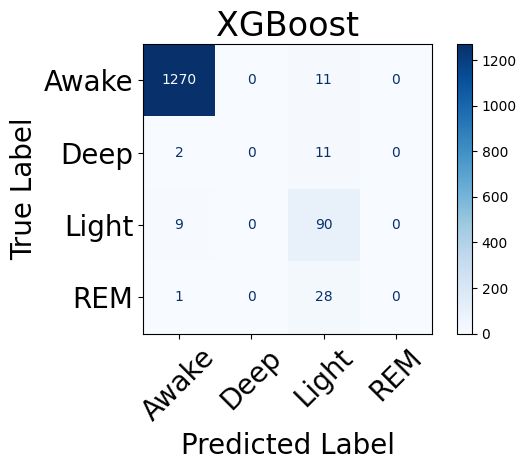

In [213]:
#XGBoost
X = df.drop(columns=["Sleep stage", "Timestamp"])

# 2. Define the raw model (not in pipeline yet!)
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)

# 3. RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1
)

# 4. Fit RFECV and transform X
X_selected = rfecv.fit_transform(X, y)


# Plot RFECV performance
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
    marker='o',
    label="F1 Macro Score"
)
plt.xlabel("Number of Selected Features", fontsize=20)
plt.ylabel("Cross-Validated F1 Macro Score", fontsize=20)
plt.title("RFECV Results for XGBoost", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()

# Save the plot
graph_path = os.path.expanduser("~/Desktop/xgboost_rfecv_plot.png")
plt.savefig(graph_path, dpi=300)
plt.show()

print("Selected features:", X.columns[rfecv.support_].tolist())

# 5. Now prepare your pipeline with scaling and the same model
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", xgb)
])

# 6. Define the hyperparameter grid
xgb_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 6],
    "xgb__learning_rate": [0.1, 0.01]
}

# 7. Call your existing training function using the reduced feature set
best_xgb = train_and_evaluate(X_selected, y, xgb_pipeline, xgb_grid, model_name="XGBoost", label_names=label_names, use_rfecv=False)

## Train & test

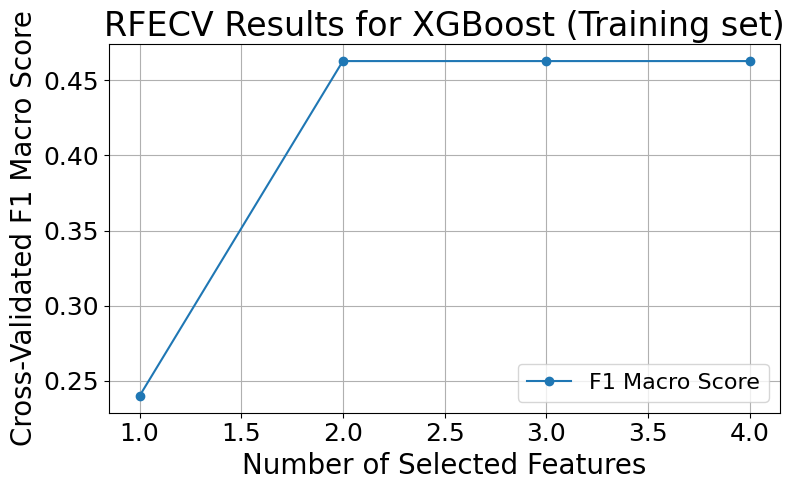

Selected features: ['Heart rate', 'Activity type']
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
Best CV F1 Macro: 0.4627
Classification report op trainingset:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5739
           1       0.00      0.00      0.00        45
           2       0.66      0.94      0.78       339
           3       0.00      0.00      0.00        95

    accuracy                           0.97      6218
   macro avg       0.41      0.48      0.44      6218
weighted avg       0.95      0.97      0.96      6218

Classification report op test set:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       663
           1       0.00      0.00      0.00        22
           2       0.62      0.90      0.73       156
           3       0.00      0.00      0.00        

C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\joell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [222]:
from sklearn.model_selection import train_test_split
# Categorieën encoderen
df["Sleep stage"] = df["Sleep stage"].astype("category").cat.codes
df["Device_type"] = df["Device_type"].astype("category").cat.codes
df["Activity type"] = df["Activity type"].astype("category").cat.codes
df["Coffee"] = df["Coffee"].astype("category").cat.codes

# Kenmerken en label
X = df.drop(columns=["Sleep stage", "Timestamp"])
y = df["Sleep stage"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.125, random_state=42, shuffle=False
)

# Definieer XGBoost model (zonder pipeline)
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42
)

# RFECV alleen op trainingsdata
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1
)

# Pas RFECV toe en selecteer features
X_train_selected = rfecv.fit_transform(X_train, y_train)
X_test_selected = rfecv.transform(X_test)  # Transformeer test data met dezelfde selectie

# Plot RFECV resultaten (training set)
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
    marker='o',
    label="F1 Macro Score"
)
plt.xlabel("Number of Selected Features", fontsize=20)
plt.ylabel("Cross-Validated F1 Macro Score", fontsize=20)
plt.title("RFECV Results for XGBoost (Training set)", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.legend(fontsize=16)
plt.tight_layout()

graph_path = os.path.expanduser("~/Desktop/xgboost_rfecv_plot.png")
plt.savefig(graph_path, dpi=300)
plt.show()

print("Selected features:", X.columns[rfecv.support_].tolist())

# Pipeline met scaling en XGBoost
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", xgb)
])

# Hyperparameter grid
xgb_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 6],
    "xgb__learning_rate": [0.1, 0.01]
}

# GridSearchCV op training set
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

# Train op geselecteerde features (training set)
grid_search.fit(X_train_selected, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV F1 Macro: {grid_search.best_score_:.4f}")

# Voorspellingen op trainingset
y_train_pred = best_xgb.predict(X_train_selected)
print("Classification report op trainingset:")
print(classification_report(y_train, y_train_pred))

# Evalueer op test set
y_pred = grid_search.predict(X_test_selected)
print("Classification report op test set:")
print(classification_report(y_test, y_pred, target_names=[str(l) for l in sorted(y.unique())]))